<a href="https://colab.research.google.com/github/laiss33/Stock-Price-Prediction-using-Multilingual-Sentiment-Analysis/blob/main/%5B1%5D_Sentiment_Anlaysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Pretain Model for multi-lingual text classification
---
in this notebook, fine the pretained model multilingual BERT and XLM-RoBERTa is carried out.


## Set-up environment

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification,XLMRobertaTokenizer,XLMRobertaForSequenceClassification,AutoModelForSequenceClassification
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
# !pip install -q transformers datasets

In [ ]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00


## Load dataset
Due to the resources limitation, the latest year news title (2023) is selected to train the pretained model to improve the accuracy of the model.

The language used to train the model is:
1. English
2. Chinese
3. Malay




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load data 5 years data
df_all = pd.read_excel('/content/drive/MyDrive/shisun_thesis/5year_news_title.xlsx')
df_all['label_id']=df_all['label'].replace(['negative','neutral','positive'],[0,1,2])
df_all

,company,news_source,news_title,datetime,language,label,label_id
0,YTL Power International,Sinchew,部分股账面值低于海啸期 ‧ 投资马股宜长期部署,2018-10-16 10:50:00,Chinese,neutral,1
1,YTL Power International,TheEdge,Tenaga could gain from future solar installati...,2018-10-23 11:02:00,English,positive,2
2,YTL Power International,TheStar,Treasury Pulse,2018-10-27 10:12:00,English,neutral,1
3,YTL Power International,TheStar,Treasury Pulse,2018-11-03 08:22:00,English,neutral,1
4,YTL Power International,Orientaldaily,終止IPP合約無影響 電力領域前景續看好,2018-11-04 19:41:00,Chinese,neutral,1
...,...,...,...,...,...,...,...
51847,PBBank (Public Bank Bhd)',Sinchew,2023年封关| 39公司市值破百亿 银行股10大占4席,2023-12-30 09:56:00,Chinese,positive,2
51848,PBBank (Public Bank Bhd)',Nanyang,净利息赚幅难大幅回升 银行股2024上半年乏力,2023-12-30 19:47:00,Chinese,negative,0
51849,CIMB Group,TheEdge,IILM appoints Mohamad Safri Shahul Hamid as ne...,2023-12-31 14:29:00,English,neutral,1
51850,Maybank,Orientaldaily,旧楼换新楼 Maybank迁入默迪卡118大楼倒计时,2023-12-31 14:42:00,Chinese,neutral,1


In [ ]:
#Load data
df = pd.read_excel('/content/drive/MyDrive/shisun_thesis/2023_news_title.xlsx')
df['label_id']=df['label'].replace(['negative','neutral','positive'],[0,1,2])
df

,company,news_source,news_title,datetime,language,label,label_id
0,CIMB Group,TheStar,YearStarter 2023: Business – What to expect in...,2023-01-01 07:10:00,English,neutral,1
1,Maybank,Nanyang,全球挑战重重·大马新政未稳 马股宜守不宜攻,2023-01-02 08:04:00,Chinese,neutral,1
2,IHH Healthcare,Nanyang,全球挑战重重·大马新政未稳 马股宜守不宜攻,2023-01-02 08:04:00,Chinese,neutral,1
3,Tenaga Nasional,Nanyang,全球挑战重重·大马新政未稳 马股宜守不宜攻,2023-01-02 08:04:00,Chinese,neutral,1
4,Maybank,Nanyang,混合式会议皆大欢喜/万年船,2023-01-02 09:12:00,Chinese,neutral,1
...,...,...,...,...,...,...,...
12181,PBBank (Public Bank Bhd)',Sinchew,2023年封关| 39公司市值破百亿 银行股10大占4席,2023-12-30 09:56:00,Chinese,positive,2
12182,PBBank (Public Bank Bhd)',Nanyang,净利息赚幅难大幅回升 银行股2024上半年乏力,2023-12-30 19:47:00,Chinese,negative,0
12183,CIMB Group,TheEdge,IILM appoints Mohamad Safri Shahul Hamid as ne...,2023-12-31 14:29:00,English,neutral,1
12184,Maybank,Orientaldaily,旧楼换新楼 Maybank迁入默迪卡118大楼倒计时,2023-12-31 14:42:00,Chinese,neutral,1


## Preprocessing


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51852 entries, 0 to 51851
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   company      51852 non-null  object        
 1   news_source  51852 non-null  object        
 2   news_title   51852 non-null  object        
 3   datetime     51852 non-null  datetime64[ns]
 4   language     51852 non-null  object        
 5   label        51852 non-null  object        
 6   label_id     51852 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 2.8+ MB


In [ ]:
#check for null
df_all.isnull().sum()

company        0
news_source    0
news_title     0
datetime       0
language       0
label          0
label_id       0
dtype: int64

In [ ]:
#count for each class
df_all.company.value_counts()

company
PBBank (Public Bank Bhd)'           9092
CIMB Group                          9092
Maybank                             9047
Tenaga Nasional                     8034
IHH Healthcare                      4473
(HLBank) Hong Leong Bank            4340
PChem (Petronas Chemicals Group)    4203
PMetal (Press Metal Aluminium)      1497
Celcomdigi                          1286
YTL Power International              788
Name: count, dtype: int64

<Axes: xlabel='company'>

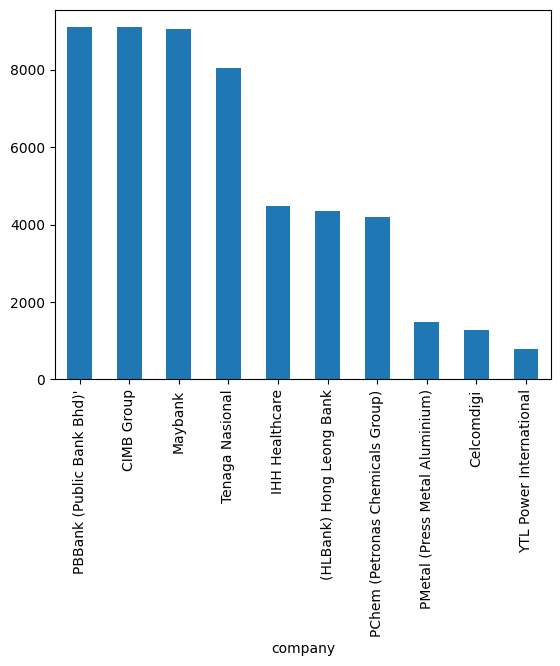

In [ ]:
df_all.company.value_counts().plot.bar()

In [ ]:
#count for each class
df_all.news_source.value_counts()

news_source
TheEdge          22901
TheStar          12388
Sinchew           5577
Nanyang           4493
BeritaHarian      2392
Orientaldaily     1337
NST               1318
Chinapress        1276
HarianMetro        170
Name: count, dtype: int64

In [ ]:
#count for each class
df_all.language.value_counts()

language
English    30394
Chinese    18896
Malay       2562
Name: count, dtype: int64

<Axes: xlabel='language'>

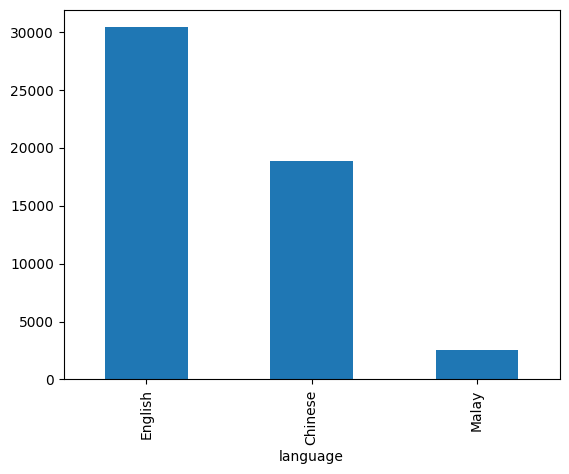

In [ ]:
df_all.language.value_counts().plot.bar()

<ipython-input-19-5ba7b7ec7720>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_all.language, palette='Spectral')


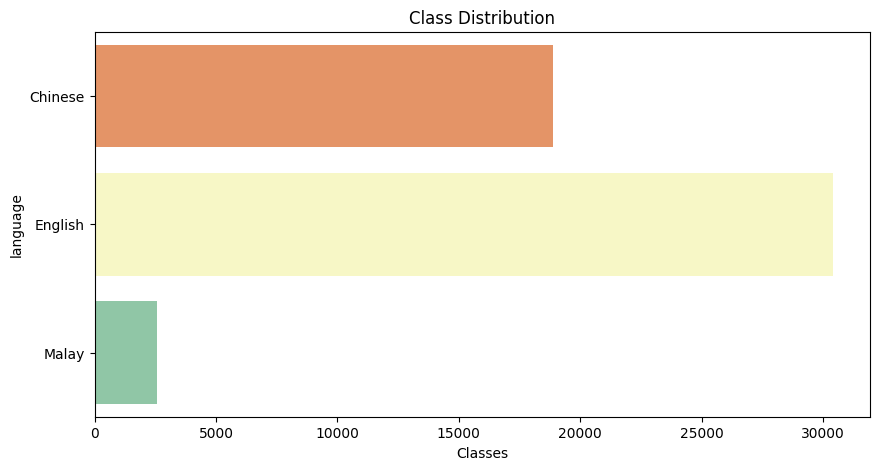

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(df_all.language, palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution');

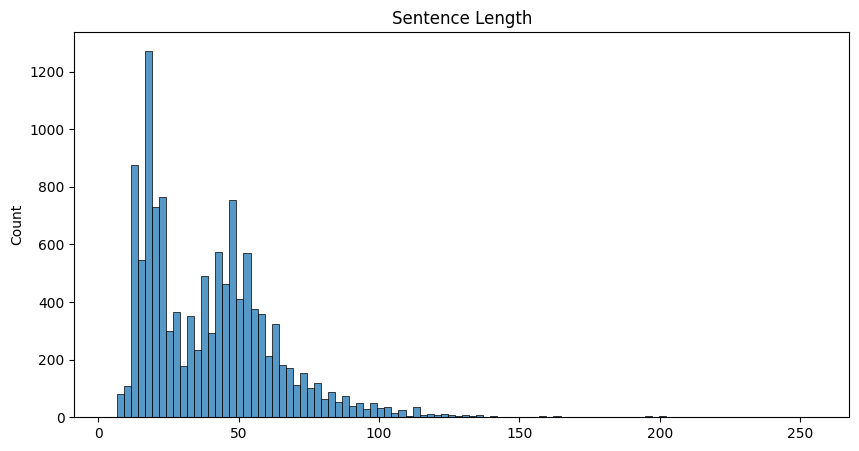

In [ ]:
#need equal length sentences
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df.news_title], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
#find the maximum length
max_len = max([len(s) for s in df.news_title])
print('Max length: ', max_len)

Max length:  255


In [ ]:
summary = pd.DataFrame(columns = df_all['language'].unique())
temp=[0,0,0]
summary.loc['positive']=temp
summary.loc['neutral']=temp
summary.loc['negative']=temp
summary.loc['total']=temp
for lang in df_all['language'].unique():
    pos=df_all.loc[(df_all.language == lang)]['label'].value_counts()[2]
    neu=df_all.loc[(df_all.language == lang)]['label'].value_counts()[1]
    neg=df_all.loc[(df_all.language == lang)]['label'].value_counts()[0]
    summary.loc['negative'][lang]=neg
    summary.loc['positive'][lang]=pos
    summary.loc['neutral'][lang]=neu
    summary.loc['total'][lang]=pos+neg+neu
summary['total'] = summary.sum(axis=1)
summary

,Chinese,English,Malay,total
positive,4295,8767,76,13138
neutral,7283,10128,1208,18619
negative,7318,11499,1278,20095
total,18896,30394,2562,51852


As we can see, the dataset contains 3 splits: one for training, one for validation and one for testing.

In [ ]:
train_df,  test_df = train_test_split(df, test_size=0.25, random_state=0, shuffle=True)

In [ ]:
import datasets
from datasets import Dataset
train_df = Dataset.from_dict(train_df)
test_df = Dataset.from_dict(test_df)
df_new = datasets.DatasetDict({"train":train_df,"test":test_df})

In [ ]:
df_new

DatasetDict({
    train: Dataset({
        features: ['company', 'news_source', 'news_title', 'datetime', 'language', 'label', 'label_id'],
        num_rows: 9139
    })
    test: Dataset({
        features: ['company', 'news_source', 'news_title', 'datetime', 'language', 'label', 'label_id'],
        num_rows: 3047
    })
})

Let's check the first example of the training split:

In [ ]:
example = df_new['train'][0]
example

{'company': 'Maybank',
 'news_source': 'TheEdge',
 'news_title': '不敌套利活动 马股开盘走低',
 'datetime': datetime.datetime(2023, 4, 26, 9, 44),
 'language': 'Chinese',
 'label': 'positive',
 'label_id': 2}

The dataset consists of tweets, labeled with one or more emotions.

Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
sentiment_labels = ["negative","neutral","positive"]
id2label = {idx:label for idx, label in enumerate(sentiment_labels)}
label2id = {label:idx for idx, label in enumerate(sentiment_labels)}

id2label

{0: 'negative', 1: 'neutral', 2: 'positive'}

# Fine-tuning mBERT

---





## Preprocess data

As models like BERT don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `BertTokenizer` API, which will  load the tokenizer for mBERT model.


In [ ]:
mbert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
def preprocess_data(examples,tokenizer):
  # take a batch of texts
  text = examples["news_title"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: True if examples["label"] == k else False for k in sentiment_labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(sentiment_labels)))
  # fill numpy array
  for idx, label in enumerate(sentiment_labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix[0].tolist()
  return encoding

In [ ]:
mbert_encoded_df = df_new.map(preprocess_data, remove_columns=df_new['train'].column_names,fn_kwargs={"tokenizer":mbert_tokenizer})

Map:   0%|          | 0/9139 [00:00<?, ? examples/s]

Map:   0%|          | 0/3047 [00:00<?, ? examples/s]

In [ ]:
pd.DataFrame(mbert_encoded_df['train'])

,input_ids,token_type_ids,attention_mask,labels
0,"[101, 2080, 4288, 3223, 2551, 4978, 2601, 8551...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0.0, 0.0, 1.0]"
1,"[101, 13690, 15074, 131, 43076, 57965, 24874, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"
2,"[101, 8551, 8084, 7069, 2733, 7326, 8576, 2527...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"
3,"[101, 3014, 4929, 2649, 3365, 10186, 119, 126,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"
4,"[101, 62154, 17981, 10106, 11732, 18908, 117, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
...,...,...,...,...
9134,"[101, 62154, 60971, 10107, 92193, 10114, 14087...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1.0, 0.0, 0.0]"
9135,"[101, 43376, 11676, 19307, 62154, 13625, 13697...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1.0, 0.0, 0.0]"
9136,"[101, 62154, 13625, 72986, 10347, 22549, 98899...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]"
9137,"[101, 10281, 19757, 117, 58335, 10440, 13820, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"


In [ ]:
example = mbert_encoded_df['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
mbert_tokenizer.decode(example['input_ids'])

'[CLS] 不 敌 套 利 活 动 马 股 开 盘 走 低 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
example['labels']

[0.0, 0.0, 1.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['positive']

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets](https://pytorch.org/docs/stable/data.html).

In [ ]:
mbert_encoded_df.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.


In [ ]:
from transformers import AutoModelForSequenceClassification

mbert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(sentiment_labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                                 )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate Pretained Model


In [ ]:
def get_prediction(dataset,tokenizer,model):
    # encodings=encodings.remove_columns(['labels'])
    inputs = tokenizer(dataset['news_title'],'padding=True' 'truncation=True',return_tensors='pt')
    inputs = {k: v.to(model.device) for k,v in inputs.items()}
    outputs = model(**inputs)
    predictions=outputs.logits
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred=torch.argmax(probs).item()
    dataset['predicted_label_id']=y_pred


    return dataset

In [ ]:
def evaluate(y_actual,y_predict):
  label_names = ['negative', 'neutral', 'positive']

  print(classification_report(y_actual, y_predict,target_names=sentiment_labels))
  data = confusion_matrix(y_actual, y_predict)
  df_cm = pd.DataFrame(data, columns=np.unique(y_actual), index = np.unique(y_actual))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10,7))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:
mbert_predictions=df_new['test'].map(get_prediction,fn_kwargs={"tokenizer":mbert_tokenizer,'model':mbert_model})


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1087
     neutral       0.24      0.92      0.39       718
    positive       0.51      0.14      0.22      1242

    accuracy                           0.27      3047
   macro avg       0.25      0.35      0.20      3047
weighted avg       0.27      0.27      0.18      3047



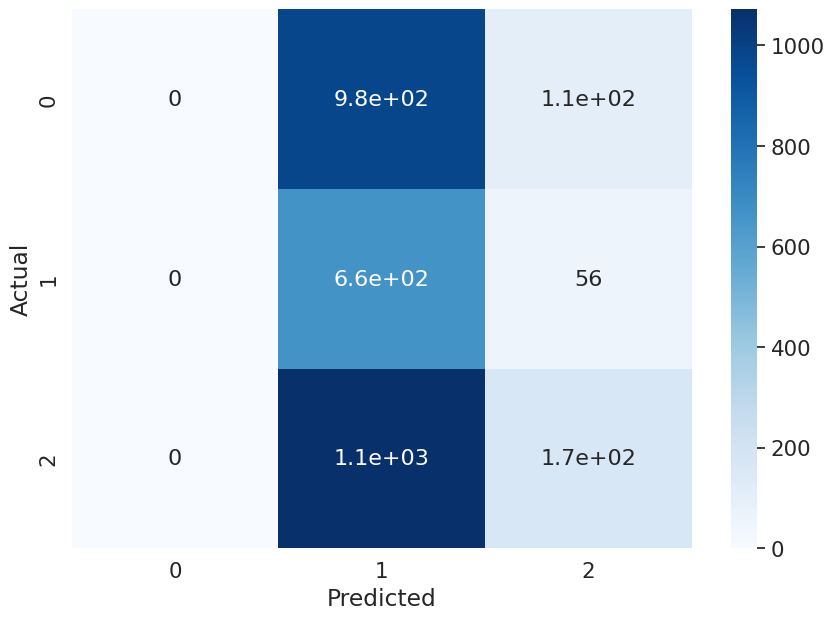

In [ ]:
evaluate(mbert_predictions['label_id'],mbert_predictions['predicted_label_id'])

In [ ]:
def get_prediction_2(news_title,tokenizer,model):
    # encodings=encodings.remove_columns(['labels'])
    inputs = tokenizer(news_title,'padding=True' 'truncation=True',return_tensors='pt')
    inputs = {k: v.to(model.device) for k,v in inputs.items()}
    outputs = model(**inputs)
    predictions=outputs.logits
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred=torch.argmax(probs).item()
    # dataset['predicted_label_id']=y_pred


    return y_pred

In [ ]:
## get 5year_predict data
tqdm.pandas()
df_all['mbert_predicted_sentiment'] = df_all['news_title'].progress_apply(lambda x: get_prediction_2(x, mbert_tokenizer, mbert_model))

## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
* a `Trainer` object (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [ ]:
batch_size = 8
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"/content/drive/MyDrive/shisun_thesis/mbert_model/bert-finetuned-sem_eval-english",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    # load_best_model_at_end=True,
    # metric_for_best_model=metric_name,
    #push_to_hub=True,
)

Let's verify a batch as well as a forward pass:

In [ ]:
#forward pass
outputs = mbert_model(input_ids=mbert_encoded_df['train']['input_ids'][0].unsqueeze(0), labels=mbert_encoded_df['train'][0]['labels'].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.6774, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.0204, -0.3560, -0.2362]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(outputs.logits))

y_pred = np.zeros(probs.shape)
y_pred[:, torch.argmax(probs).item()] = 1
y_pred

array([[1., 0., 0.]])

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(outputs.logits))

y_pred = np.zeros(probs.shape)
y_pred[np.where(probs >= 0.5)] = 1
y_pred[0]

array([0., 0., 0.])

In [ ]:
y_true = mbert_encoded_df['train'][0]['labels']
y_true

tensor([0., 0., 1.])

In [ ]:
mbert_encoded_df['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
mbert_encoded_df['train']['input_ids'][0]

tensor([ 101, 2080, 4288, 3223, 2551, 4978, 2601, 8551, 6510, 3701, 5745, 7528,
        2247,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# multi_label_metrics(outputs.logits, mbert_encoded_df['train'][0]['labels'])

In [ ]:
mbert_trainer = Trainer(
    mbert_model,
    args,
    train_dataset=mbert_encoded_df["train"],
    eval_dataset=mbert_encoded_df["test"],
    tokenizer=mbert_tokenizer
    # compute_metrics=compute_metrics
)

In [ ]:
mbert_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.347700,0.326656


TrainOutput(global_step=1143, training_loss=0.39298327388412996, metrics={'train_runtime': 321.5728, 'train_samples_per_second': 28.42, 'train_steps_per_second': 3.554, 'total_flos': 601148381154048.0, 'train_loss': 0.39298327388412996, 'epoch': 1.0})

## Evaluate

After training, we evaluate our model on the validation set.

In [ ]:
mbert_finetune_predictions=df_new['test'].map(get_prediction,fn_kwargs={"tokenizer":mbert_tokenizer,'model':mbert_trainer.model})

Map:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.91      0.47      0.62      1087
     neutral       0.75      0.70      0.72       718
    positive       0.61      0.88      0.72      1242

    accuracy                           0.69      3047
   macro avg       0.75      0.68      0.69      3047
weighted avg       0.75      0.69      0.68      3047



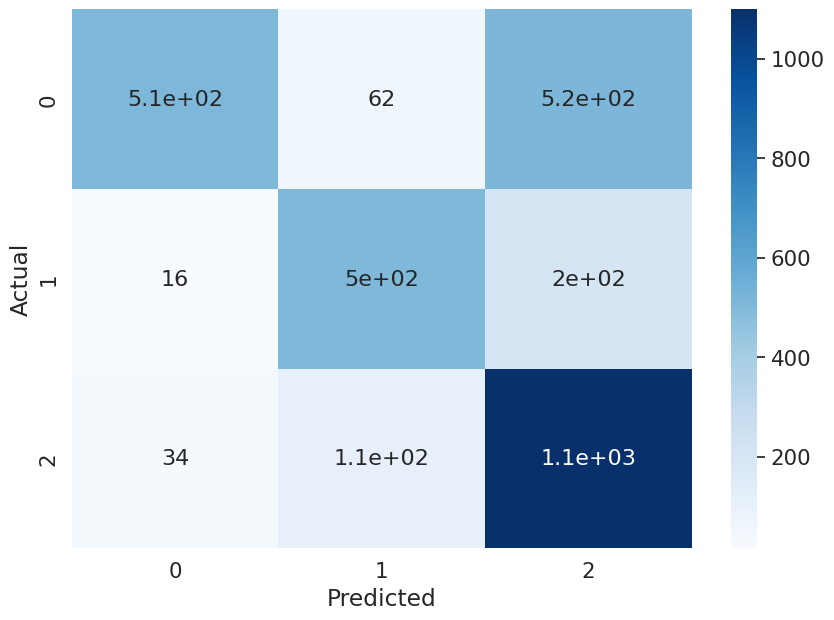

In [ ]:
evaluate(mbert_finetune_predictions['label_id'],mbert_finetune_predictions['predicted_label_id'])

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.95      0.29      0.45       484
     neutral       0.74      0.80      0.77       430
    positive       0.60      0.88      0.72       668

    accuracy                           0.68      1582
   macro avg       0.77      0.66      0.64      1582
weighted avg       0.75      0.68      0.65      1582



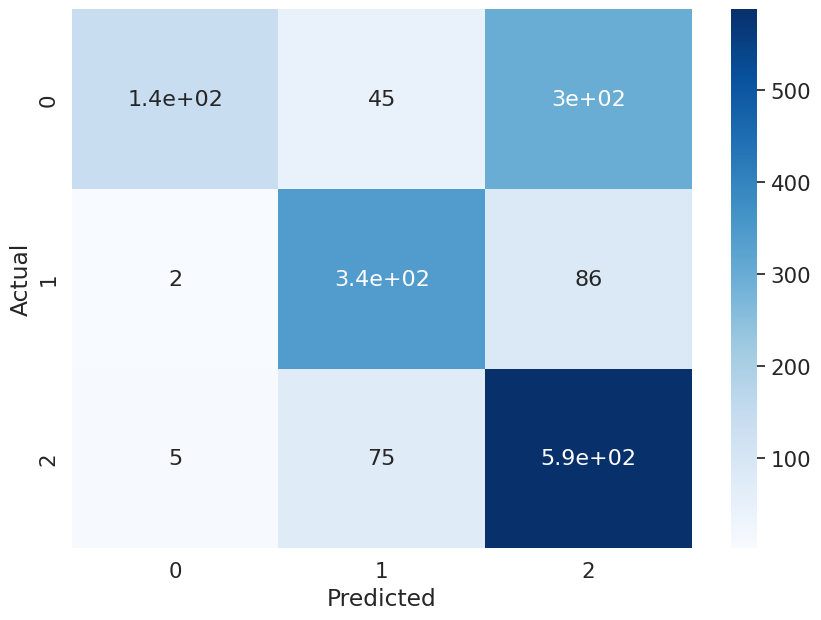

In [ ]:
evaluate(mbert_finetune_predictions.filter(lambda example: example["language"]=='English')['label_id'],mbert_finetune_predictions.filter(lambda example: example["language"]=='English')['predicted_label_id'])

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.89      0.67      0.77       460
     neutral       0.77      0.57      0.65       279
    positive       0.61      0.87      0.72       437

    accuracy                           0.72      1176
   macro avg       0.76      0.70      0.71      1176
weighted avg       0.76      0.72      0.72      1176



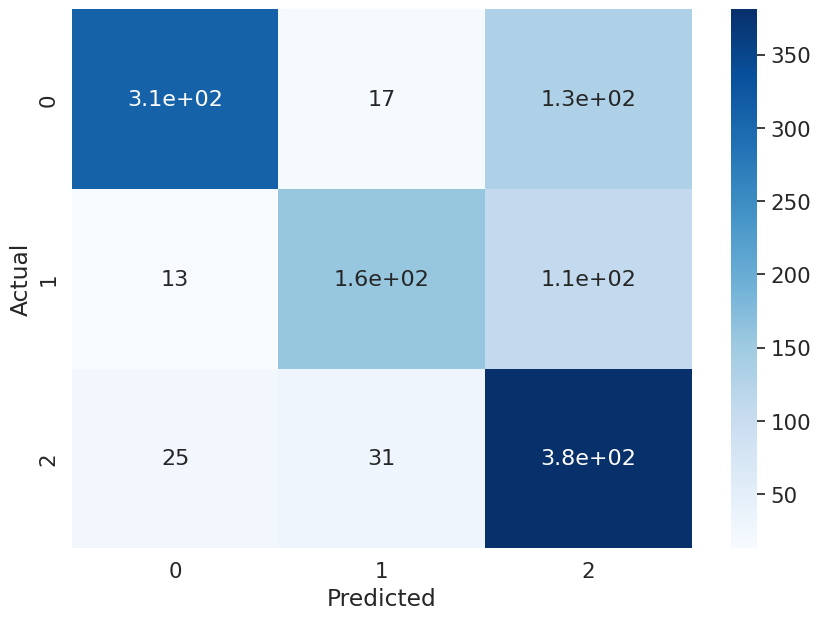

In [ ]:
evaluate(mbert_finetune_predictions.filter(lambda example: example["language"]=='Chinese')['label_id'],mbert_finetune_predictions.filter(lambda example: example["language"]=='Chinese')['predicted_label_id'])

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.92      0.41      0.57       143
     neutral       0.50      0.33      0.40         9
    positive       0.59      0.95      0.73       137

    accuracy                           0.66       289
   macro avg       0.67      0.56      0.57       289
weighted avg       0.75      0.66      0.64       289



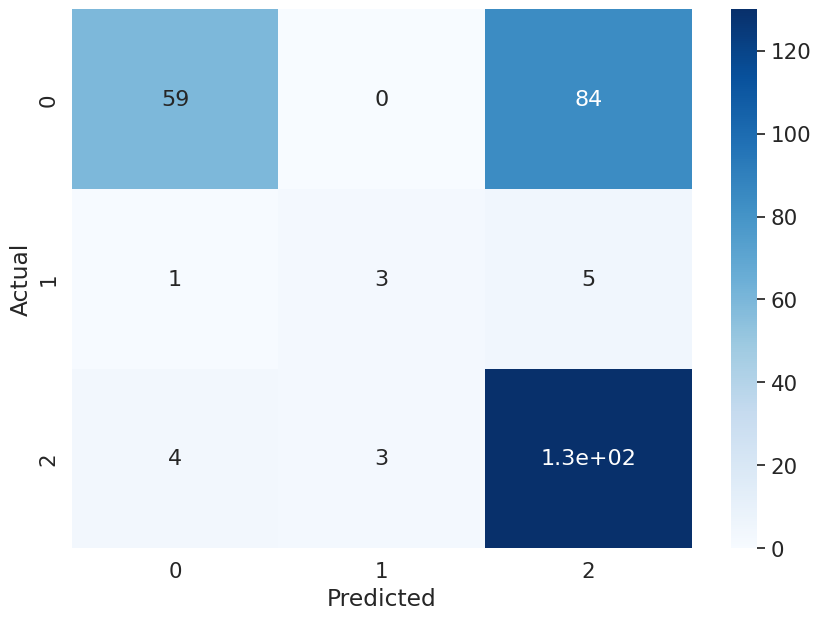

In [ ]:
evaluate(mbert_finetune_predictions.filter(lambda example: example["language"]=='Malay')['label_id'],mbert_finetune_predictions.filter(lambda example: example["language"]=='Malay')['predicted_label_id'])

In [ ]:
# result= trainer.evaluate()

## Inference

Let's test the model on a new sentence:

In [ ]:
text = "Nasional Tenage predict will close at higher price"

encoding = mbert_tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

The logits that come out of the model are of shape (batch_size, num_labels). As we are only forwarding a single sentence through the model, the `batch_size` equals 1. The logits is a tensor that contains the (unnormalized) scores for every individual label.

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 3])

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['positive']


In [ ]:
mbert_trainer = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/shisun_thesis/mbert_model")

In [ ]:
tqdm.pandas()
df_all['mbert_finetune_predicted_sentiment'] = df_all['news_title'].progress_apply(lambda x: get_prediction_2(x, mbert_tokenizer, mbert_trainer))

100%|██████████| 51852/51852 [2:27:05<00:00,  5.88it/s]


In [ ]:
df_all.to_excel('/content/drive/MyDrive/shisun_thesis/5_year_sentiment_finetune_mbert_20240527.xlsx')

In [ ]:
mbert_trainer.save_model("/content/drive/MyDrive/shisun_thesis/mbert_model")

the fine tune model is saved locally to predict the sentiment of the remaining news title for stock price prediction

In [ ]:
finetune_mbert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/shisun_thesis/mbert_model")

In [ ]:
mbert_trainer = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/shisun_thesis/mbert_model")

# Fine-tuning XLM-RoBERTa

---





## Preprocess data

As XLM-RoBERTa don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `BertTokenizer` API, which will  load the tokenizer for mBERT model.


In [ ]:
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
xlm_encoded_df = df_new.map(preprocess_data, remove_columns=df_new['train'].column_names,fn_kwargs={"tokenizer":xlm_tokenizer})

In [ ]:
pd.DataFrame(xlm_encoded_df['train'])

,input_ids,attention_mask,labels
0,"[0, 6, 562, 103865, 14046, 3908, 7005, 6, 5958...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 1.0]"
1,"[0, 25132, 34798, 12, 16777, 7, 41725, 42, 285...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"
2,"[0, 6, 5958, 14565, 7606, 206054, 1040, 1378, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"
3,"[0, 6, 3024, 6858, 66121, 418, 48413, 20798, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"
4,"[0, 42871, 77546, 23, 39395, 52350, 4, 10267, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[1.0, 0.0, 0.0]"
...,...,...,...
9134,"[0, 42871, 39531, 5908, 21647, 7, 47, 9803, 92...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]"
9135,"[0, 180409, 14509, 42871, 3605, 1143, 6781, 18...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[1.0, 0.0, 0.0]"
9136,"[0, 42871, 3605, 117057, 770, 72815, 9, 72815,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0]"
9137,"[0, 636, 5037, 4, 3658, 344, 16713, 4, 5787, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 1.0, 0.0]"


In [ ]:
example = xlm_encoded_df['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [ ]:
xlm_tokenizer.decode(example['input_ids'])

'<s> 不敌套利活动 马股开盘走低</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [ ]:
example['labels']

[0.0, 0.0, 1.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['positive']

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets](https://pytorch.org/docs/stable/data.html).

In [ ]:
xlm_encoded_df.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.


In [ ]:
from transformers import AutoModelForSequenceClassification

xlm_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(sentiment_labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                                 )

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate Pretained Model

In [ ]:
xlm_predictions=df_new['test'].map(get_prediction,fn_kwargs={"tokenizer":xlm_tokenizer,'model':xlm_model})


Map:   0%|          | 0/3047 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.36      1.00      0.53      1087
     neutral       0.00      0.00      0.00       718
    positive       0.00      0.00      0.00      1242

    accuracy                           0.36      3047
   macro avg       0.12      0.33      0.18      3047
weighted avg       0.13      0.36      0.19      3047



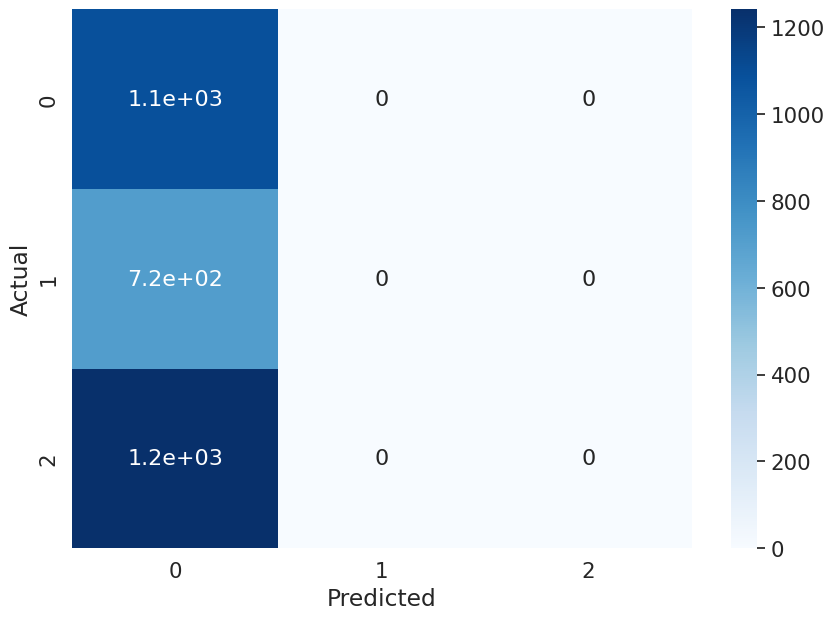

In [ ]:
evaluate(predictions['label_id'],predictions['predicted_label_id'])

In [ ]:
## get 5year_predict data
tqdm.pandas()
df_all['xlm_predicted_sentiment'] = df_all['news_title'].progress_apply(lambda x: get_prediction_2(x, xlm_tokenizer, xlm_model))

## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
* a `Trainer` object (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [ ]:
batch_size = 8
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"/content/drive/MyDrive/shisun_thesis/xlm_model/pretained_xlm",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
    # load_best_model_at_end=True,
    # metric_for_best_model=metric_name,
    #push_to_hub=True,
)

We are also going to compute metrics while training. For this, we need to define a `compute_metrics` function, that returns a dictionary with the desired metric values.

Let's verify a batch as well as a forward pass:

In [ ]:
#forward pass
outputs = xlm_model(input_ids=xlm_encoded_df['train']['input_ids'][0].unsqueeze(0), labels=xlm_encoded_df['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7402, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[0.2656, 0.0877, 0.0928]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(outputs.logits))

y_pred = np.zeros(probs.shape)
y_pred[:, torch.argmax(probs).item()] = 1
y_pred

array([[1., 0., 0.]])

In [ ]:
y_true = xlm_encoded_df['train'][0]['labels']
y_true

tensor([0., 0., 1.])

In [ ]:
xlm_encoded_df['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
xlm_encoded_df['train']['input_ids'][0]

tensor([     0,      6,    562, 103865,  14046,   3908,   7005,      6,   5958,
         13250,   4185,  27964,   3469,   4814,      2,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [ ]:
xlm_trainer = Trainer(
    xlm_model,
    args,
    train_dataset=xlm_encoded_df["train"],
    eval_dataset=xlm_encoded_df["test"],
    tokenizer=mbert_tokenizer
    # compute_metrics=compute_metrics
)

In [ ]:
xlm_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.391300,0.340712


TrainOutput(global_step=1143, training_loss=0.4502880767261575, metrics={'train_runtime': 363.0209, 'train_samples_per_second': 25.175, 'train_steps_per_second': 3.149, 'total_flos': 601148381154048.0, 'train_loss': 0.4502880767261575, 'epoch': 1.0})

## Evaluate

After training, we evaluate our model on the validation set.

In [ ]:
fine_tune_predictions=df_new['test'].map(get_prediction,fn_kwargs={"tokenizer":xlm_tokenizer,'model':finetune_xlm})

Map:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.82      0.85      0.84      1087
     neutral       0.69      0.77      0.72       718
    positive       0.85      0.76      0.80      1242

    accuracy                           0.79      3047
   macro avg       0.78      0.79      0.79      3047
weighted avg       0.80      0.79      0.80      3047



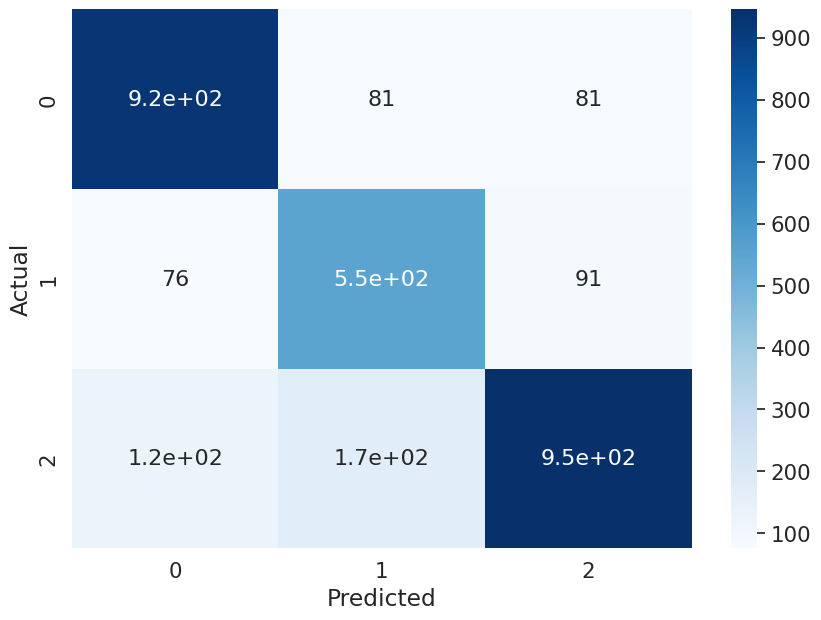

In [ ]:
evaluate(fine_tune_predictions['label_id'],fine_tune_predictions['predicted_label_id'])

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80       484
     neutral       0.70      0.81      0.75       430
    positive       0.84      0.78      0.81       668

    accuracy                           0.79      1582
   macro avg       0.78      0.79      0.79      1582
weighted avg       0.79      0.79      0.79      1582



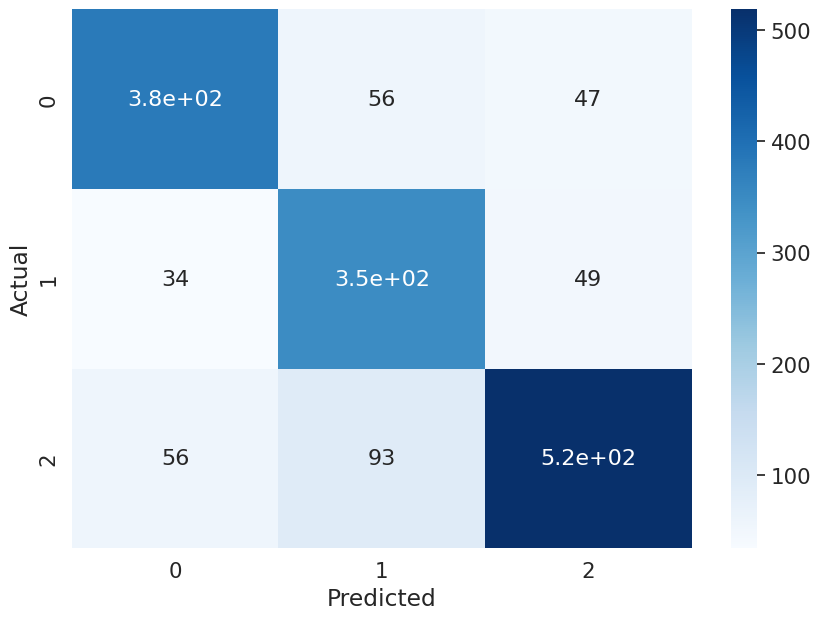

In [ ]:
evaluate(fine_tune_predictions.filter(lambda example: example["language"]=='English')['label_id'],fine_tune_predictions.filter(lambda example: example["language"]=='English')['predicted_label_id'])

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.81      0.90      0.85       460
     neutral       0.74      0.71      0.72       279
    positive       0.83      0.76      0.80       437

    accuracy                           0.80      1176
   macro avg       0.80      0.79      0.79      1176
weighted avg       0.80      0.80      0.80      1176



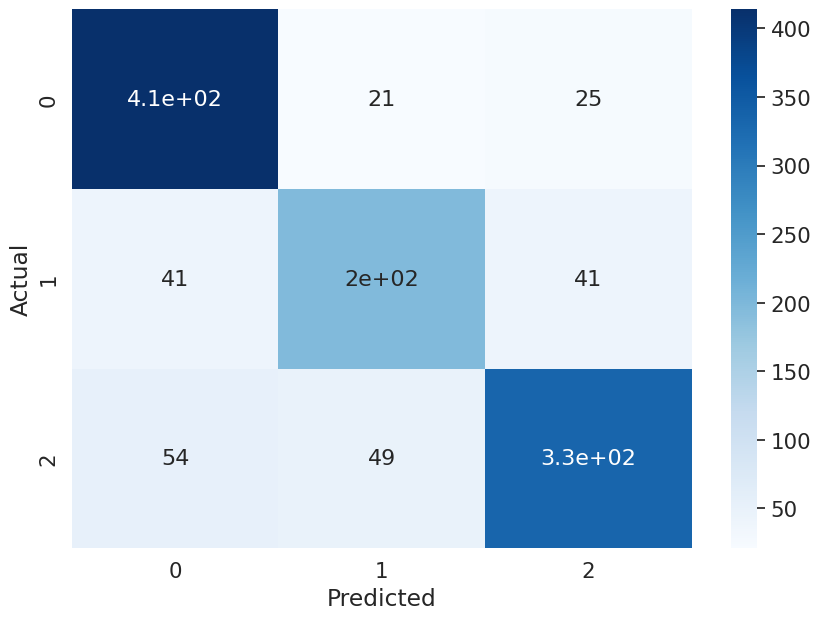

In [ ]:
evaluate(fine_tune_predictions.filter(lambda example: example["language"]=='Chinese')['label_id'],fine_tune_predictions.filter(lambda example: example["language"]=='Chinese')['predicted_label_id'])

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3047 [00:00<?, ? examples/s]

              precision    recall  f1-score   support

    negative       0.90      0.91      0.90       143
     neutral       0.17      0.78      0.28         9
    positive       0.90      0.68      0.78       137

    accuracy                           0.80       289
   macro avg       0.66      0.79      0.65       289
weighted avg       0.88      0.80      0.82       289



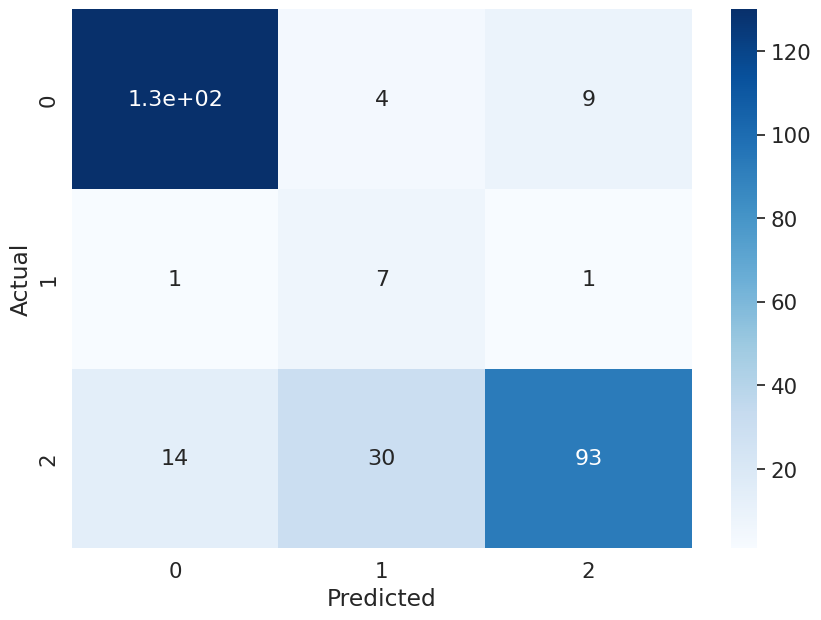

In [ ]:
evaluate(fine_tune_predictions.filter(lambda example: example["language"]=='Malay')['label_id'],fine_tune_predictions.filter(lambda example: example["language"]=='Malay')['predicted_label_id'])

In [ ]:
# result= trainer.evaluate()

## Inference

Let's test the model on a new sentence:

In [ ]:
text = df_new['train'][0]['news_title']

encoding = xlm_tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

The logits that come out of the model are of shape (batch_size, num_labels). As we are only forwarding a single sentence through the model, the `batch_size` equals 1. The logits is a tensor that contains the (unnormalized) scores for every individual label.

In [ ]:
logits = outputs.logits
logits

tensor([[-2.4726,  1.5353, -2.0442]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
y_pred = np.zeros(probs.shape)
y_pred[torch.argmax(probs).item()] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['neutral']


In [ ]:
y_pred[torch.argmax(probs).item()] = 1
y_pred

array([0., 1., 0.])

In [ ]:
df_all['xlm_finetune_predicted_sentiment'] = df_all['news_title'].progress_apply(lambda x: get_prediction_2(x, xlm_tokenizer, finetune_xlm.model))

100%|██████████| 51852/51852 [2:45:17<00:00,  5.23it/s]


In [ ]:
df_all.to_excel('/content/drive/MyDrive/shisun_thesis/5_year_sentiment_finetune_mbert_xlm.xlsx')

In [ ]:
xlm_trainer.save_model("/content/drive/MyDrive/shisun_thesis/xlm_model")

the fine tune model is saved locally to predict the sentiment of the remaining news title for stock price prediction

In [ ]:
finetune_xlm = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/shisun_thesis/xlm_model")